In [6]:
pip install seaborn tqdm

  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached tzdata-2023.4-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.9 MB/s eta 0:00:00ta 0:00:01
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 67.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 118.5 MB/s eta 0:00:00
Using cached tzdata-2023.4-py2.py3-none-any.whl (346 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [55]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

def compute_metric(data_list, labels_list, dim=148):
    data = torch.tensor(np.array(data_list)).to(device) 
    overall_data_mean = torch.mean(data, dim=0)
    bcss = torch.zeros(dim, device=device)
    wcss = torch.zeros(dim, device=device)

    unique_labels = list(set(labels_list))
    
    #unique_labels = [label for label in unique_labels if not label in ['label_inpaint black square']]
    
    label_dict = {label: index for index, label in enumerate(unique_labels)}
    labels_list_number = torch.tensor([label_dict[label] for label in labels_list]).to(device)

    for group_label in set(labels_list_number):
        
        group_indices = torch.nonzero(labels_list_number == group_label, as_tuple=False).squeeze()
        group_data = data[group_indices]
        
        group_mean = torch.mean(group_data, dim=0)

        current_bcss = len(group_indices) * torch.sum((group_mean - overall_data_mean) ** 2, dim=1)
        current_wcss = torch.sum((group_data - group_mean) ** 2, dim=(0,2))

        bcss += current_bcss
        wcss += current_wcss

    ratios = bcss / wcss
    assert ratios.shape[0] == dim
    return ratios.cpu()

In [5]:
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    z = iter(h5file.values())
    first_element = next(z)
    print(first_element.keys())

<KeysViewHDF5 ['colorization', 'colorization_neutral', 'inpaint single random', 'inpaint single random_neutral', 'lowlight enhance', 'lowlight enhance_neutral', 'segmentation', 'segmentation_neutral']>


In [58]:
alpha_labels = ['inpaint single random',  'lowlight enhance', 'segmentation', ]

In [14]:
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    ele = first_element["colorization"]["encoder_latent"][...]


In [18]:
# Open the file in read mode
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['segmentation']['encoder_latent'].shape[0]
    decoder_layers = first_element['segmentation']['decoder_latent'].shape[0]
    print(encoder_layers, decoder_layers)
    for i in tqdm(range(encoder_layers)):
        for head in range(16):
            data_list = []
            labels_list = []
            for pass_name, pass_group in h5file.items():
                if pass_name.startswith('pass_'):
                    label_level = []    
                    for label_name, label_group in pass_group.items():
                        if label_name in alpha_labels:
                            item = label_group['encoder_latent'][i][0][:,head].copy()
                            print(item.shape)
                            label_level.append(item)
                            labels_list.append(label_name)
                        
                    data_list.extend(label_level)

            # Compute metric and append to holder
            regular = compute_metric(data_list, labels_list)
            encoder_metric_holder.append(regular)

24 8


  0%|          | 0/24 [00:00<?, ?it/s]

(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)
(148, 64)


  0%|          | 0/24 [00:02<?, ?it/s]

(148, 64)
(148, 64)


KeyboardInterrupt: 

In [57]:
alpha_labels = ["colorization", "inpaint single random", "lowlight enhance"]

In [59]:
import h5py
import torch
import numpy as np
from tqdm import tqdm

def load_data(h5file_path):
    data_store = {}
    with h5py.File(h5file_path, 'r') as h5file:
        for pass_name, pass_group in tqdm(h5file.items()):
            if pass_name.startswith('pass_'):
                data_store[pass_name] = {}
                for label_name, label_group in pass_group.items():
                    if label_name in alpha_labels:
                        # Read the entire dataset for this label in this pass

                        item = label_group['decoder_latent'][:, 0, :, :]- pass_group[label_name+"_neutral"]['decoder_latent'][:, 0, :, :]
                        print(np.linalg.norm(label_group['decoder_latent'][:, 0, :, :]), np.linalg.norm(item))
                        data_store[pass_name][label_name] = item
    return data_store

def compute_metric_for_layer_and_head(data, labels, layer, head, dim=148):
    # Slice the data for the specific layer and head
    data_list = [d[layer, :, head] for d in data]
    return compute_metric(data_list, labels, dim)

# Load data once
data_store = load_data("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5")


  1%|          | 1/170 [00:00<00:48,  3.49it/s]

379.77292 251.1366
377.6816 252.77849
389.08398 362.3184


  1%|          | 2/170 [00:00<00:53,  3.12it/s]

389.62006 237.84717
385.62436 248.43883
391.96014 349.21082
394.42474 269.66193


  2%|▏         | 4/170 [00:01<00:39,  4.19it/s]

392.97238 295.26144
393.96014 365.40814
392.55762 254.84897
388.4228 273.06146
396.55154 368.33746
376.21942 246.64621
376.96573 273.31863


  4%|▎         | 6/170 [00:01<00:41,  3.98it/s]

385.0225 370.37384
391.69507 238.77744
389.8524 267.26065
391.6183 367.4009


  4%|▍         | 7/170 [00:01<00:39,  4.11it/s]

388.76904 243.06279
389.3599 280.2089
395.70474 393.87466
389.2023 230.29636


  5%|▍         | 8/170 [00:02<00:40,  4.02it/s]

385.97964 239.64117
388.25214 372.07086
392.2372 274.4165
389.30624 285.11563


  5%|▌         | 9/170 [00:02<00:41,  3.92it/s]

395.2735 357.3132
392.97644 265.45917
390.90823 280.1476


  6%|▌         | 10/170 [00:02<00:41,  3.87it/s]

392.60434 369.2373
390.50467 265.37903


  6%|▋         | 11/170 [00:03<00:50,  3.16it/s]

389.42044 295.43835
391.5475 382.27588
396.79028 270.2378


  7%|▋         | 12/170 [00:03<00:48,  3.27it/s]

393.87808 285.36996
396.75534 362.2167


  8%|▊         | 13/170 [00:03<00:47,  3.32it/s]

385.1248 249.2458
381.84845 264.7738
385.57953 373.12146
379.58246 254.36961
380.39532 273.59552


  8%|▊         | 14/170 [00:04<00:52,  2.96it/s]

389.5333 359.28622
379.88013 253.40463


  9%|▉         | 15/170 [00:04<00:56,  2.74it/s]

372.00824 270.0514
387.9659 344.0825


  9%|▉         | 16/170 [00:04<00:51,  2.97it/s]

384.62787 244.883
378.43918 255.19145
394.77603 353.36176


 10%|█         | 17/170 [00:05<00:46,  3.26it/s]

381.5273 256.72723
381.02594 264.01385
387.89316 358.90936
385.63986 258.2609


 11%|█         | 18/170 [00:05<00:51,  2.97it/s]

381.85287 273.53433
389.82526 348.76825


 11%|█         | 19/170 [00:05<00:46,  3.22it/s]

380.18387 256.7898
376.09692 268.07373
387.83722 326.54053
383.3129 266.8891


 12%|█▏        | 20/170 [00:05<00:45,  3.32it/s]

376.95172 282.83426
385.4215 360.13507
379.64215 263.58524
378.3329 274.94617


 13%|█▎        | 22/170 [00:06<00:41,  3.57it/s]

398.2293 373.60812
381.6272 267.76556
378.04617 259.82736
389.20175 358.99033
387.675 258.34708
382.764 261.53268


 14%|█▎        | 23/170 [00:06<00:46,  3.13it/s]

394.23724 397.8163
401.91098 258.63403


 14%|█▍        | 24/170 [00:07<00:51,  2.86it/s]

397.3192 259.26376
398.74823 379.49667


 15%|█▍        | 25/170 [00:07<00:42,  3.44it/s]

379.8149 242.07086
377.6016 258.816
389.71704 362.57474
384.44864 234.8672


 15%|█▌        | 26/170 [00:07<00:40,  3.51it/s]

382.19537 251.39888
389.19858 349.60382


 16%|█▌        | 27/170 [00:08<00:39,  3.60it/s]

392.31445 245.1432
390.0393 261.86493
396.1821 374.21475
385.46323 233.53322


 16%|█▋        | 28/170 [00:08<00:38,  3.70it/s]

384.62772 259.19412
388.6152 361.96323
386.2645 250.13876


 17%|█▋        | 29/170 [00:08<00:32,  4.30it/s]

382.16702 259.81177
385.7504 358.30396
386.76724 239.84276


 18%|█▊        | 30/170 [00:08<00:36,  3.87it/s]

382.05334 260.9557
393.26083 379.49603
387.21466 240.9797
385.55658 260.34076


 18%|█▊        | 31/170 [00:08<00:35,  3.94it/s]

386.49896 377.10776
387.68497 240.10957


 19%|█▉        | 32/170 [00:09<00:36,  3.78it/s]

385.5614 257.06796
392.42432 379.6548
390.65027 247.05272
388.22247 276.16885


 19%|█▉        | 33/170 [00:09<00:44,  3.10it/s]

395.69836 378.81238


 20%|██        | 34/170 [00:10<00:47,  2.86it/s]

392.79785 249.77618
385.9783 257.90594
395.21155 352.60696
391.1841 247.39095


 21%|██        | 35/170 [00:10<00:44,  3.03it/s]

388.2473 261.82446
396.3413 368.6477
392.01627 249.12872


 21%|██        | 36/170 [00:10<00:47,  2.81it/s]

388.104 269.5436
400.56894 365.91727


 22%|██▏       | 37/170 [00:11<00:42,  3.12it/s]

388.02405 242.57124
385.71426 265.7692
394.75427 373.935
377.37033 233.96732


 22%|██▏       | 38/170 [00:11<00:40,  3.29it/s]

377.00204 257.33862
384.45898 375.35114


 23%|██▎       | 39/170 [00:11<00:43,  3.00it/s]

382.88596 239.80347
380.04474 265.52542
388.58197 363.56528
386.50052 252.02179
382.48535 268.88647


 24%|██▍       | 41/170 [00:12<00:35,  3.64it/s]

385.99155 355.77948
384.59378 257.7712
380.16138 276.62885
388.7526 363.2936


 25%|██▍       | 42/170 [00:12<00:35,  3.57it/s]

386.72034 259.11548
385.74533 272.35257
391.9089 376.14078


 25%|██▌       | 43/170 [00:12<00:35,  3.56it/s]

389.21906 288.2864
383.97824 275.25195
388.31512 375.2141
389.0197 255.03354


 26%|██▌       | 44/170 [00:13<00:36,  3.46it/s]

381.2642 267.37015
389.676 351.44156
387.60513 257.73175
386.10635 276.99332


 26%|██▋       | 45/170 [00:13<00:33,  3.72it/s]

389.84332 363.50916
392.2633 260.8081
385.31488 268.94107


 28%|██▊       | 47/170 [00:13<00:32,  3.73it/s]

392.348 366.14618
394.29617 265.36996
388.18472 264.97733
397.51883 372.9175
390.37448 260.7079


 29%|██▉       | 49/170 [00:14<00:27,  4.43it/s]

385.10706 270.4824
395.134 365.2642
380.5017 250.0562
379.58682 260.1817
390.81552 351.30786


 29%|██▉       | 50/170 [00:14<00:33,  3.59it/s]

380.42844 250.09831
380.32623 259.04492
387.7031 371.80008
378.93314 246.3872
379.47263 257.1739


 30%|███       | 51/170 [00:15<00:36,  3.28it/s]

385.48462 361.3193
379.33994 231.62987


 31%|███       | 52/170 [00:15<00:38,  3.04it/s]

377.2483 254.49683
387.4923 353.5628
386.42487 276.899
385.66495 287.25714


 32%|███▏      | 54/170 [00:15<00:31,  3.63it/s]

387.60928 350.9237
392.70154 251.49304
391.93542 270.3115
390.02344 373.65994


 32%|███▏      | 55/170 [00:16<00:31,  3.67it/s]

396.57294 255.38286
393.503 276.88925
393.41122 364.8159


 33%|███▎      | 56/170 [00:16<00:35,  3.17it/s]

389.37518 274.53232
385.28 276.19873
388.95062 328.05518


 34%|███▎      | 57/170 [00:16<00:33,  3.35it/s]

384.60663 241.61531
382.71826 263.5259
396.8585 395.37024


 34%|███▍      | 58/170 [00:17<00:31,  3.56it/s]

378.4754 261.03296
378.116 276.65768
394.64966 394.07175
380.62335 276.13727
376.10934 268.5765


 35%|███▍      | 59/170 [00:17<00:26,  4.14it/s]

388.40506 377.25043
389.2337 229.62648


 35%|███▌      | 60/170 [00:17<00:29,  3.71it/s]

384.47046 250.21643
398.1895 387.37296
384.74298 257.46613


 36%|███▌      | 61/170 [00:17<00:32,  3.38it/s]

376.97952 266.22076
389.28607 370.70047


 36%|███▋      | 62/170 [00:18<00:34,  3.10it/s]

380.87592 242.29488
372.73248 254.84465
389.55804 375.23264


 37%|███▋      | 63/170 [00:18<00:31,  3.37it/s]

385.43018 249.69563
382.49692 255.31892
391.77393 383.61182


 38%|███▊      | 64/170 [00:18<00:31,  3.40it/s]

375.4423 241.79782
374.8659 252.55511
388.84903 360.60306
386.12662 241.71716
383.4499 256.07156


 38%|███▊      | 65/170 [00:19<00:28,  3.64it/s]

396.4664 387.86234
378.03226 253.19444
377.99173 266.54623


 39%|███▉      | 66/170 [00:19<00:36,  2.83it/s]

388.06232 349.28314
378.1971 248.08911
377.18262 260.62204


 40%|████      | 68/170 [00:20<00:31,  3.29it/s]

383.71765 380.73282
391.6636 254.10818
387.53116 261.51172
393.4209 383.7086
383.4396 247.85156
380.6113 267.56714


 41%|████      | 69/170 [00:20<00:32,  3.15it/s]

389.5806 377.42038
377.14694 245.52489
378.26086 277.6381


 41%|████      | 70/170 [00:20<00:36,  2.75it/s]

384.06284 377.05872
380.8809 243.91675
379.30533 262.2311


 42%|████▏     | 71/170 [00:21<00:37,  2.62it/s]

390.11 376.38867
385.37753 260.2743


 42%|████▏     | 72/170 [00:21<00:34,  2.83it/s]

382.91672 279.87534
391.4492 391.47964
400.2061 249.40027


 43%|████▎     | 73/170 [00:21<00:31,  3.10it/s]

397.78903 264.22903
396.33835 366.70486
390.51855 260.9207


 44%|████▎     | 74/170 [00:22<00:29,  3.24it/s]

387.25836 277.35956
391.8399 364.19647
385.78604 255.11017
382.16882 281.43073


 44%|████▍     | 75/170 [00:22<00:25,  3.67it/s]

388.07288 371.97098
382.729 259.83463


 45%|████▍     | 76/170 [00:22<00:29,  3.14it/s]

382.99747 270.97183
391.34943 384.20856
376.4862 259.51947
378.73392 280.58148


 45%|████▌     | 77/170 [00:23<00:30,  3.07it/s]

384.57077 374.6931
385.15765 264.39365


 46%|████▌     | 78/170 [00:23<00:37,  2.48it/s]

387.06757 272.3106
397.70245 379.0692
382.09677 245.57622
382.1791 259.6704


 46%|████▋     | 79/170 [00:24<00:35,  2.53it/s]

388.67697 364.8814
377.0007 256.3666
378.85046 257.63657


 47%|████▋     | 80/170 [00:24<00:33,  2.66it/s]

390.22498 368.13647
388.9757 255.91501


 48%|████▊     | 81/170 [00:24<00:30,  2.89it/s]

381.78873 254.03992
395.80447 357.456
385.5132 239.23805


 48%|████▊     | 82/170 [00:25<00:28,  3.12it/s]

383.56137 251.05263
395.52933 360.16943
394.54904 241.82663


 49%|████▉     | 83/170 [00:25<00:27,  3.13it/s]

391.6259 263.18933
401.74146 358.26257
381.6905 233.03622
377.8572 260.11636


 50%|█████     | 85/170 [00:25<00:22,  3.74it/s]

389.79803 377.9812
388.48303 242.88312
387.05252 268.11993
390.15814 380.0564
387.07285 243.18874


 51%|█████     | 86/170 [00:26<00:31,  2.70it/s]

385.87787 257.30518
394.36768 370.85184


 51%|█████     | 87/170 [00:26<00:30,  2.75it/s]

380.88776 234.40915
380.7895 256.0371
391.319 374.583
393.70068 248.882
390.50046 268.3605


 52%|█████▏    | 88/170 [00:27<00:27,  2.94it/s]

383.12924 387.19073
385.8689 249.20596


 52%|█████▏    | 89/170 [00:27<00:25,  3.13it/s]

385.49582 264.2095
387.3843 364.21338
383.67337 250.66298
379.6067 261.37125


 53%|█████▎    | 90/170 [00:27<00:24,  3.22it/s]

389.82803 365.02936
385.16074 243.11472


 54%|█████▎    | 91/170 [00:27<00:24,  3.22it/s]

386.34943 270.31546
391.2435 389.02917
392.17203 235.92053


 54%|█████▍    | 92/170 [00:28<00:26,  2.93it/s]

388.42035 254.80566
398.0713 372.25525


 55%|█████▍    | 93/170 [00:28<00:22,  3.43it/s]

384.45758 249.09723
379.55154 266.3751
387.81863 373.72775
382.13556 254.17519
379.19858 246.52602


 55%|█████▌    | 94/170 [00:29<00:30,  2.52it/s]

391.43866 349.61526
383.8738 249.06726
381.851 264.9577


 56%|█████▌    | 95/170 [00:29<00:25,  2.95it/s]

390.35922 368.09332
385.5257 247.71399


 56%|█████▋    | 96/170 [00:29<00:26,  2.84it/s]

378.90146 257.57663
391.62802 369.99768
377.54074 237.37465
379.26773 255.11572


 57%|█████▋    | 97/170 [00:29<00:21,  3.47it/s]

386.122 364.11313
391.43912 231.6737
385.20117 250.63359


 58%|█████▊    | 98/170 [00:30<00:19,  3.76it/s]

396.90945 382.77863
390.06638 278.79504
386.90536 289.72394


 58%|█████▊    | 99/170 [00:30<00:20,  3.39it/s]

394.05737 362.34705
380.76486 246.90634
381.39267 268.1279


 59%|█████▉    | 100/170 [00:30<00:20,  3.48it/s]

387.61246 376.80035
377.26807 241.27461
378.47427 259.94516


 59%|█████▉    | 101/170 [00:30<00:19,  3.58it/s]

387.83514 376.4481
383.38123 243.2648
383.89728 264.42386


 60%|██████    | 102/170 [00:31<00:26,  2.54it/s]

387.57144 374.53732
384.5314 242.309


 61%|██████    | 103/170 [00:31<00:25,  2.59it/s]

383.46027 264.52332
389.0766 376.42657
386.61777 242.71631


 61%|██████    | 104/170 [00:32<00:21,  3.00it/s]

381.27597 252.37933
397.35413 364.99872
385.79626 245.11717
381.89172 255.20699


 62%|██████▏   | 105/170 [00:32<00:24,  2.63it/s]

393.28812 368.78845
386.64346 229.57448
384.4864 245.24062


 62%|██████▏   | 106/170 [00:32<00:21,  3.00it/s]

393.79822 373.52255
388.18735 264.01025


 63%|██████▎   | 107/170 [00:33<00:22,  2.76it/s]

384.8548 274.89896
389.24792 382.02872
385.83466 254.3051


 64%|██████▎   | 108/170 [00:33<00:21,  2.93it/s]

386.32263 280.3132
391.53842 368.7314
376.0114 247.02531
375.69754 263.90625


 64%|██████▍   | 109/170 [00:33<00:19,  3.07it/s]

383.25897 381.34412
386.74072 259.83118


 65%|██████▌   | 111/170 [00:34<00:15,  3.77it/s]

385.4541 275.0461
394.21722 383.88922
375.03665 254.29991
374.85147 273.9809
386.60965 372.17752
382.58862 260.40222


 66%|██████▌   | 112/170 [00:34<00:16,  3.53it/s]

389.43616 287.10547
390.94308 365.32352
383.6948 238.4301
386.20267 270.96616


 67%|██████▋   | 114/170 [00:35<00:13,  4.06it/s]

397.62546 393.88065
376.81076 249.95761
377.42337 249.78706
389.61627 360.70575
383.61057 252.78331
385.04132 279.3399


 68%|██████▊   | 116/170 [00:36<00:19,  2.78it/s]

389.8255 380.07492
383.5978 234.47841
380.23672 252.39838
394.73535 369.62207
381.9001 257.32635
376.39957 264.9902


 69%|██████▉   | 118/170 [00:36<00:17,  2.98it/s]

389.8616 349.01215
379.90704 250.19911
374.93954 256.44913
386.25107 369.1092
377.9445 232.04163


 71%|███████   | 120/170 [00:37<00:13,  3.61it/s]

372.32465 250.03702
386.95255 352.3466
369.266 228.10089
367.24936 253.88174
382.80127 373.881


 71%|███████   | 121/170 [00:37<00:12,  4.05it/s]

377.75607 248.72443
377.1988 261.27853
382.62167 370.5661
377.07434 220.7087
375.7357 240.10136


 72%|███████▏  | 122/170 [00:37<00:14,  3.37it/s]

386.90314 362.59213
377.32288 234.5348
373.50058 269.18918


 72%|███████▏  | 123/170 [00:38<00:16,  2.93it/s]

385.59177 364.09113
370.78107 231.24788


 73%|███████▎  | 124/170 [00:38<00:16,  2.77it/s]

373.07867 251.47543
383.44373 367.4846
385.0771 255.9962
384.13217 274.665


 74%|███████▎  | 125/170 [00:39<00:17,  2.58it/s]

389.3032 383.36755
385.14023 262.8973
383.22638 271.8126


 75%|███████▍  | 127/170 [00:39<00:12,  3.40it/s]

394.15265 379.99713
370.84708 240.70642
369.72552 234.24426
391.4043 364.57855
387.10187 235.80948
386.7776 252.75122


 75%|███████▌  | 128/170 [00:40<00:12,  3.33it/s]

395.365 379.56296


 76%|███████▌  | 129/170 [00:40<00:13,  3.07it/s]

385.64105 253.91432
383.40134 278.29144
395.75308 390.62393
389.75546 230.99669


 76%|███████▋  | 130/170 [00:40<00:12,  3.16it/s]

387.66815 261.1071
400.93176 373.33716


 77%|███████▋  | 131/170 [00:41<00:12,  3.21it/s]

377.34283 256.3274
375.29083 253.31967
394.96085 345.4317
384.06754 275.66553


 78%|███████▊  | 132/170 [00:41<00:11,  3.35it/s]

380.76068 261.59863
388.84686 359.9706
384.17557 246.81902
382.24338 268.01605


 78%|███████▊  | 133/170 [00:41<00:12,  3.06it/s]

388.82434 381.9627
384.83502 252.63623
379.46765 265.7991


 79%|███████▉  | 135/170 [00:42<00:09,  3.65it/s]

391.69092 376.32785
389.15396 240.07283
385.87817 256.9627
397.598 366.9748
380.06073 253.72827


 80%|████████  | 136/170 [00:42<00:10,  3.15it/s]

374.69897 264.2817
388.6196 379.7732
365.51367 244.65776
369.1273 260.76782


 81%|████████  | 138/170 [00:43<00:09,  3.36it/s]

386.49014 354.40195
376.37326 262.22433
371.80472 257.10822
389.72665 352.56546
381.07855 242.63208


 82%|████████▏ | 139/170 [00:43<00:11,  2.72it/s]

381.2484 273.19678
388.7842 361.57602
384.10663 260.06638


 82%|████████▏ | 140/170 [00:44<00:11,  2.70it/s]

383.3957 274.3868
396.41516 373.55676
372.8262 244.15205
373.84177 237.79698


 83%|████████▎ | 141/170 [00:44<00:12,  2.37it/s]

388.63147 349.55975
375.83823 243.96144
374.43027 242.29048


 84%|████████▎ | 142/170 [00:44<00:10,  2.63it/s]

389.84235 363.5376
384.21942 257.20282
382.62796 268.9905


 84%|████████▍ | 143/170 [00:45<00:09,  2.90it/s]

391.5534 386.79257


 85%|████████▍ | 144/170 [00:45<00:08,  2.99it/s]

380.66632 247.56035
381.05368 258.53668
392.10828 388.22702
375.94818 244.62073
376.09644 240.12662


 85%|████████▌ | 145/170 [00:45<00:07,  3.52it/s]

391.0555 367.5693
375.02917 240.36365
375.16162 253.8254


 86%|████████▋ | 147/170 [00:46<00:05,  4.34it/s]

390.2857 369.29398
384.40277 237.19289
382.61578 260.5932
395.8547 387.90854


 87%|████████▋ | 148/170 [00:46<00:05,  3.79it/s]

377.87192 246.03224
377.79922 250.63196
389.74448 372.64636
390.3729 265.6175
386.86786 279.22153


 88%|████████▊ | 149/170 [00:46<00:04,  4.41it/s]

394.0795 388.71848
392.23563 256.98056
389.05887 279.07968


 89%|████████▉ | 151/170 [00:47<00:05,  3.80it/s]

389.09198 371.27277
374.36957 245.07271
374.7635 252.31992
386.2878 361.2475
379.03864 273.38083


 89%|████████▉ | 152/170 [00:47<00:05,  3.24it/s]

376.70908 262.08954
388.15933 371.54974
366.6996 261.1719
369.69095 258.17004


 90%|█████████ | 153/170 [00:47<00:04,  3.88it/s]

388.5396 361.49515
385.09006 268.43134
383.02704 286.2141


 91%|█████████ | 155/170 [00:48<00:03,  4.16it/s]

390.6699 362.44638
378.76257 256.81973
375.16574 258.9041
387.4948 378.72485
378.65002 234.44084
374.58374 254.17459


 92%|█████████▏| 156/170 [00:48<00:03,  3.76it/s]

381.9238 362.07394
377.86142 241.54965
377.79276 238.41777


 92%|█████████▏| 157/170 [00:48<00:03,  3.92it/s]

389.89276 354.71533
384.45557 262.8918


 93%|█████████▎| 158/170 [00:49<00:03,  3.79it/s]

382.03793 270.47165
396.13535 388.9263


 94%|█████████▎| 159/170 [00:49<00:03,  3.20it/s]

386.69397 257.3519
381.20828 262.48337
393.74173 369.9309
379.538 232.98914


 95%|█████████▍| 161/170 [00:50<00:02,  3.27it/s]

377.92712 245.51477
391.8428 368.81
378.3707 256.7797
380.07333 263.28354
388.47437 359.48364
379.80765 254.78993
374.35333 265.23096


 95%|█████████▌| 162/170 [00:50<00:02,  2.76it/s]

387.01486 360.50137
390.4008 228.39299
384.45465 245.45001


 96%|█████████▋| 164/170 [00:51<00:01,  3.53it/s]

390.6486 379.60953
386.45984 263.06918
378.45123 258.8494
390.023 330.759


 97%|█████████▋| 165/170 [00:51<00:01,  3.69it/s]

376.07663 246.13393
374.8913 256.00424
384.92517 377.47015
391.0898 245.4799


 98%|█████████▊| 166/170 [00:51<00:01,  3.55it/s]

383.2717 250.53957
396.5298 390.70218


 98%|█████████▊| 167/170 [00:51<00:00,  3.42it/s]

391.21933 276.76575
382.7658 266.03824
394.88776 381.83185
383.31824 254.52911
380.55573 268.60315


 99%|█████████▉| 168/170 [00:52<00:00,  3.77it/s]

388.53494 388.06274
382.46036 253.35158
375.2225 248.87317


 99%|█████████▉| 169/170 [00:52<00:00,  2.79it/s]

388.2403 370.79004
375.65567 239.72566
372.9337 251.25726


100%|██████████| 170/170 [00:52<00:00,  3.21it/s]

386.62512 373.42593


In [147]:
encoder_metric_holder = []
for layer in tqdm(range(24)):
    for head in range(16):
        data = []
        labels = []
        for pass_name, pass_data in data_store.items():
            for label_name, item in pass_data.items():
                data.append(item[layer,:,head])
                labels.append(label_name)

        regular = compute_metric(data, labels)
        encoder_metric_holder.append(regular)


100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


In [60]:
decoder_metric_holder = []
for layer in tqdm(range(8)):
    for head in range(16):
        data = []
        labels = []
        for pass_name, pass_data in data_store.items():
            for label_name, item in pass_data.items():
                data.append(item[layer,:,head])
                labels.append(label_name)

        regular = compute_metric(data, labels, dim=197)
        decoder_metric_holder.append(regular)


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


In [112]:
len(decoder_metric_holder)

128

In [ ]:
encoder_matrix = torch.vstack(encoder_metric_holder)
decoder_matrix = torch.vstack(decoder_metric_holder)
padding_width = decoder_matrix.shape[1] - encoder_matrix.shape[1]
padded_encoder_matrix = torch.nn.functional.pad(encoder_matrix, (0, padding_width))
stacked_matrix = torch.vstack([padded_encoder_matrix, decoder_matrix])

In [99]:
decoder_matrix = torch.vstack(decoder_metric_holder)
stacked_matrix = decoder_matrix

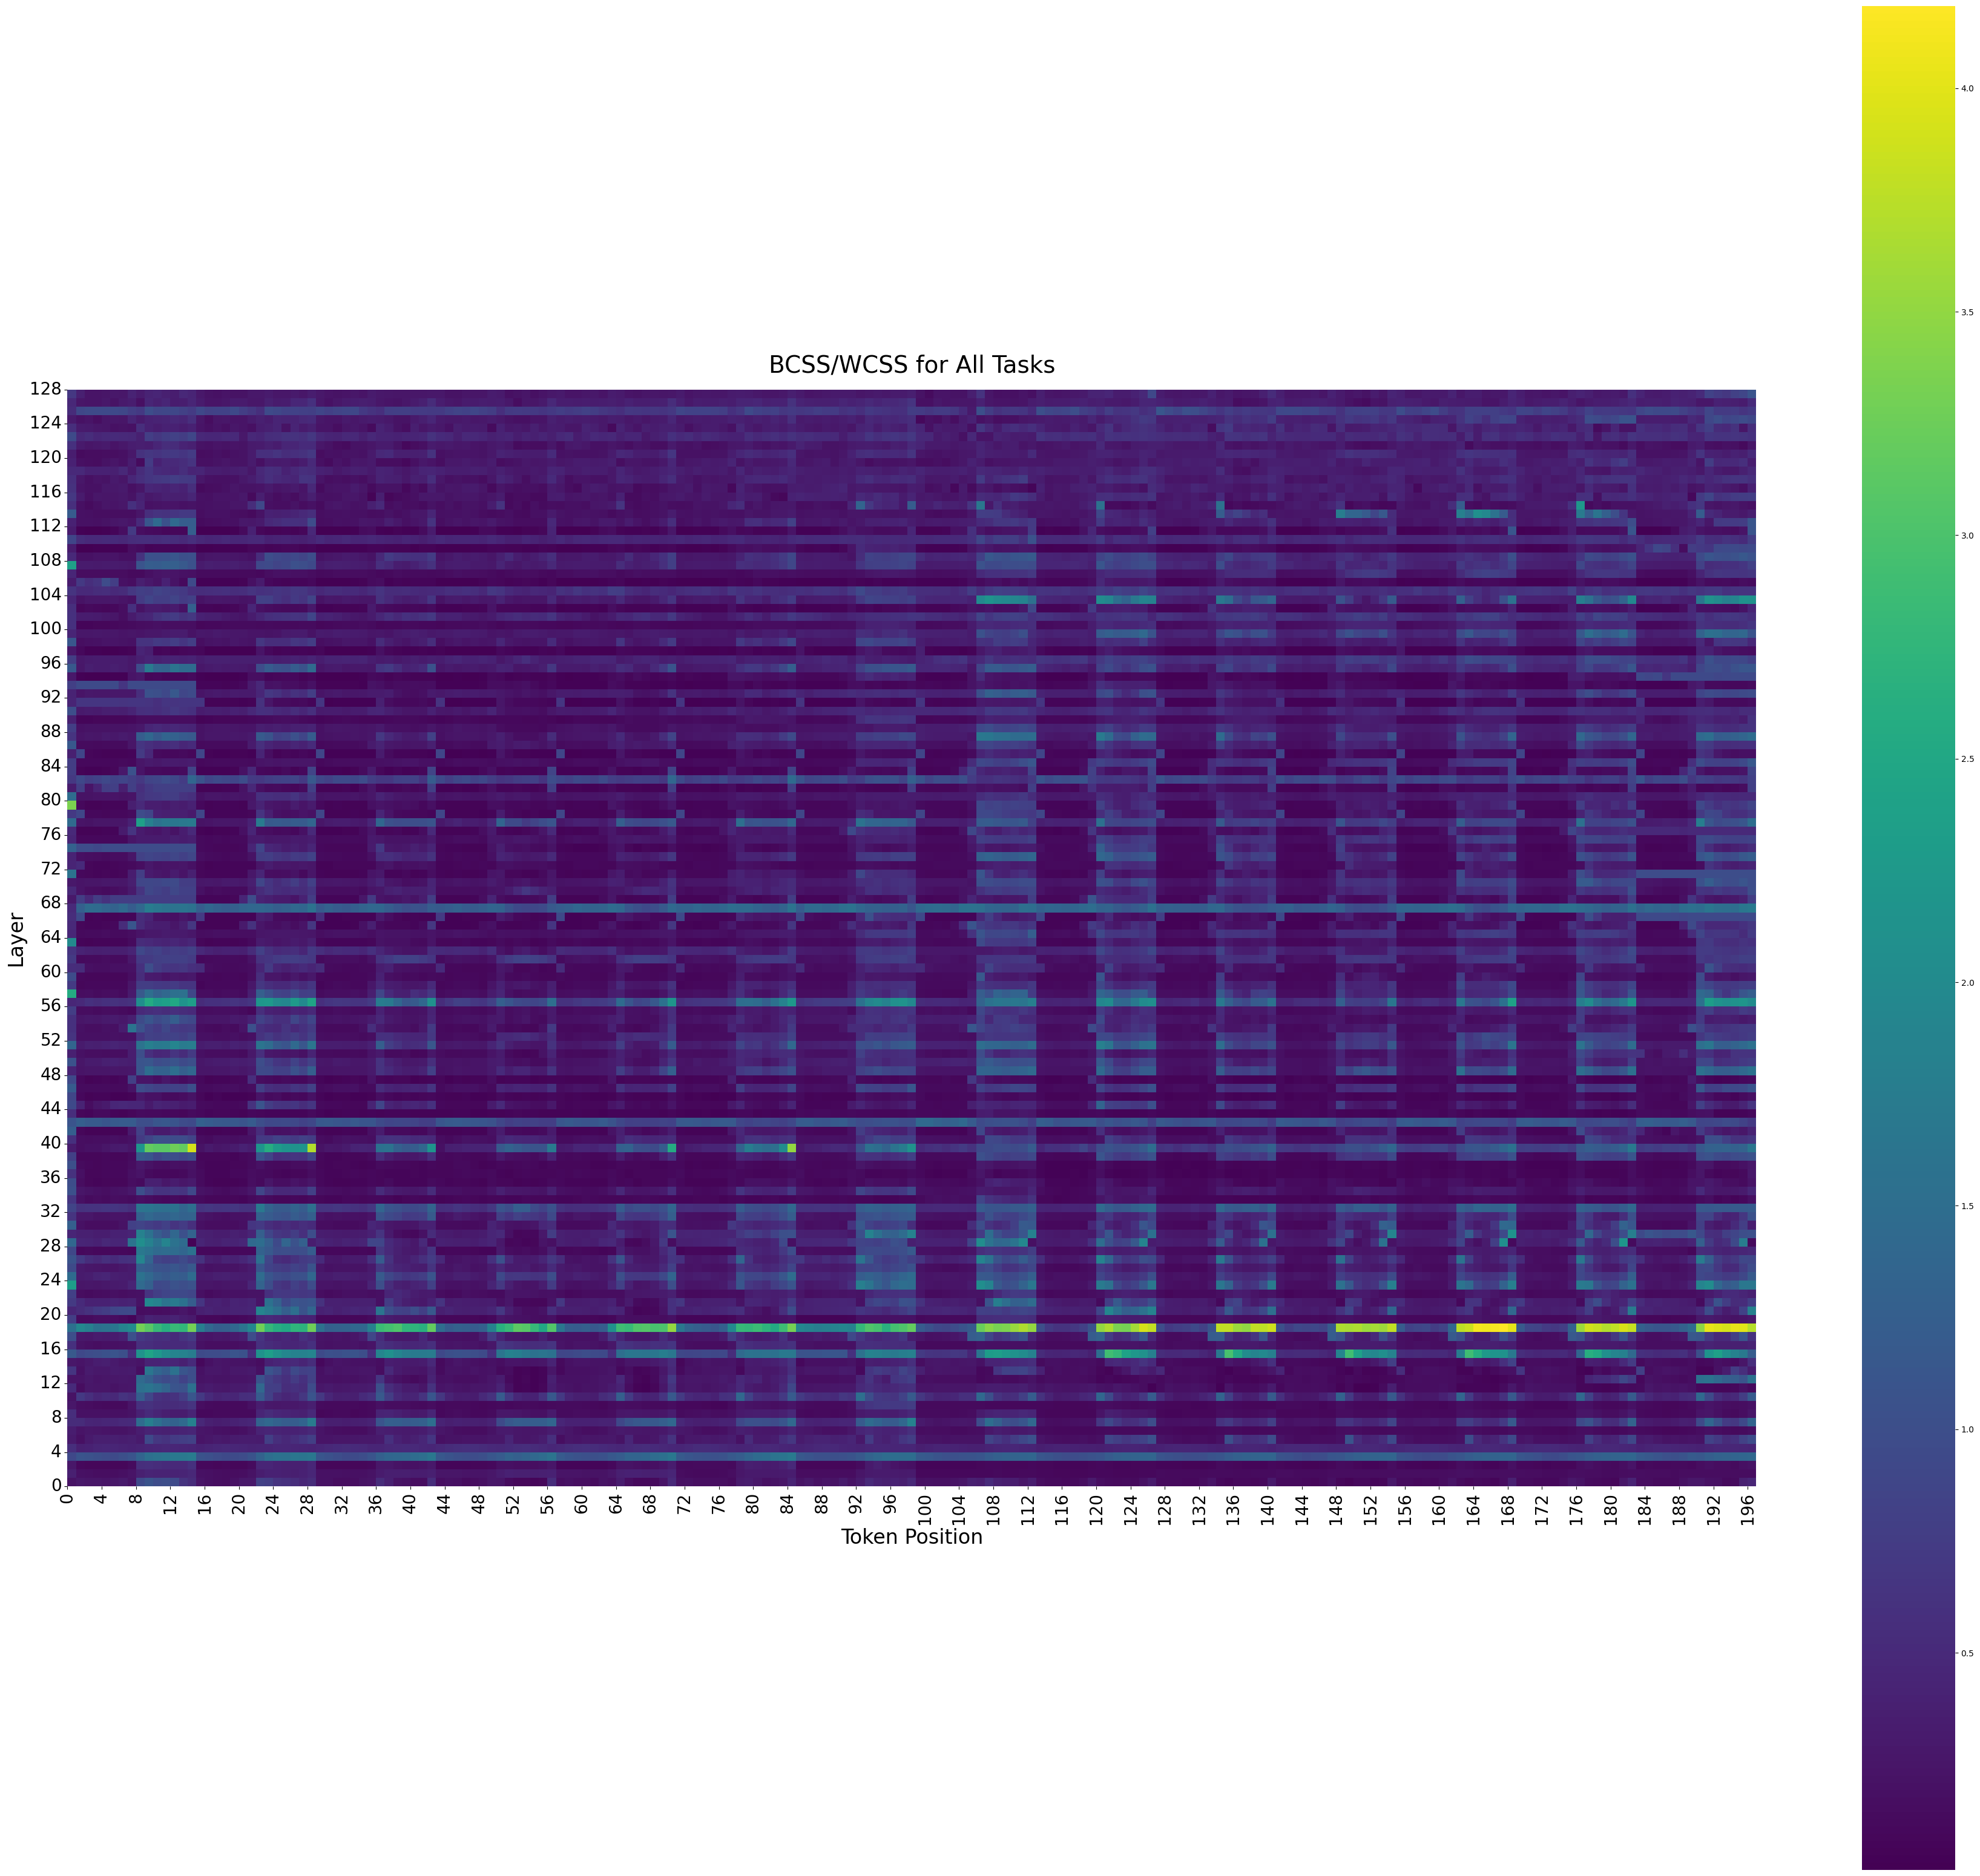

In [64]:
def plot_widemap(matrix_data, title):

    # Creating the heatmap
    plt.figure(figsize=(45, 40))  # Adjust the figure size as needed
    sns.heatmap(matrix_data, cmap='viridis', square=True)

    # Setting the labels for axes
    plt.xlabel('Token Position', fontsize=24)
    plt.ylabel('Layer', fontsize=24)

    # Inverting the y-axis to have the first layer at the bottom
    plt.gca().invert_yaxis()

    # Adding title
    plt.title(title, fontsize=28, pad=20)
    plt.yticks(np.arange(0, matrix_data.shape[0]+1, 4), np.arange(0, matrix_data.shape[0]+1, 4), fontsize=20)
    plt.xticks(np.arange(0, matrix_data.shape[1]+1, 4), np.arange(0, matrix_data.shape[1]+1, 4), fontsize=20)

    plt.show()

plot_widemap(stacked_matrix, 'BCSS/WCSS for All Tasks')

In [65]:
import torch

def unpatchify_adapted(x):
    """
    x: (N, 196)
    imgs: (N, 14, 14)
    """
    h = w = 14  # Image dimensions
    imgs = x.reshape(x.shape[0], h, w)
    return imgs

def create_special_image(pixels):
    # Initialize an empty 14x14 array
    image = torch.zeros(14, 14)

    # Fill the top half (7 rows) with the first 98 pixels
    top_half = torch.tensor(pixels[:98]).reshape(7, 14)
    image[:7, :] = top_half

    # Fill the bottom-left quadrant with the next 49 pixels
    bottom_left_quadrant = torch.tensor(pixels[98:]).reshape(7, 7)
    image[7:, :7] = bottom_left_quadrant

    return image

def batch_process(stacked_matrix, decoder_only=False, encoder_only=False):
    # Split the matrix into two parts
    if decoder_only:
        full_images = stacked_matrix
        combined = unpatchify_adapted(full_images)
    elif encoder_only:
        special_images = stacked_matrix
        combined = torch.stack([create_special_image(img) for img in special_images])
    else:
        special_images = stacked_matrix[:24, :147]  # First 24 images, first 147 pixels
        full_images = stacked_matrix[24:,]       # Last 8 images, excluding the first pixel


    # Process the special images
        special_processed = torch.stack([create_special_image(img) for img in special_images])

    # Process the full images
        full_processed = unpatchify_adapted(full_images)

    # Combine the results
        combined = torch.cat((special_processed, full_processed), dim=0)
    return combined


In [151]:
stacked_matrix.shape

torch.Size([384, 148])

In [67]:
batched_images = batch_process(stacked_matrix[:, 1:], decoder_only=True)

In [ ]:
batched_images.shape

torch.Size([128, 14, 14])

In [46]:
h = batched_images
batched_images = batched_images[:4*16]

In [50]:
batched_images = h

/tmp/ipykernel_3011980/1235543700.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the rect to account for the added colorbar axis


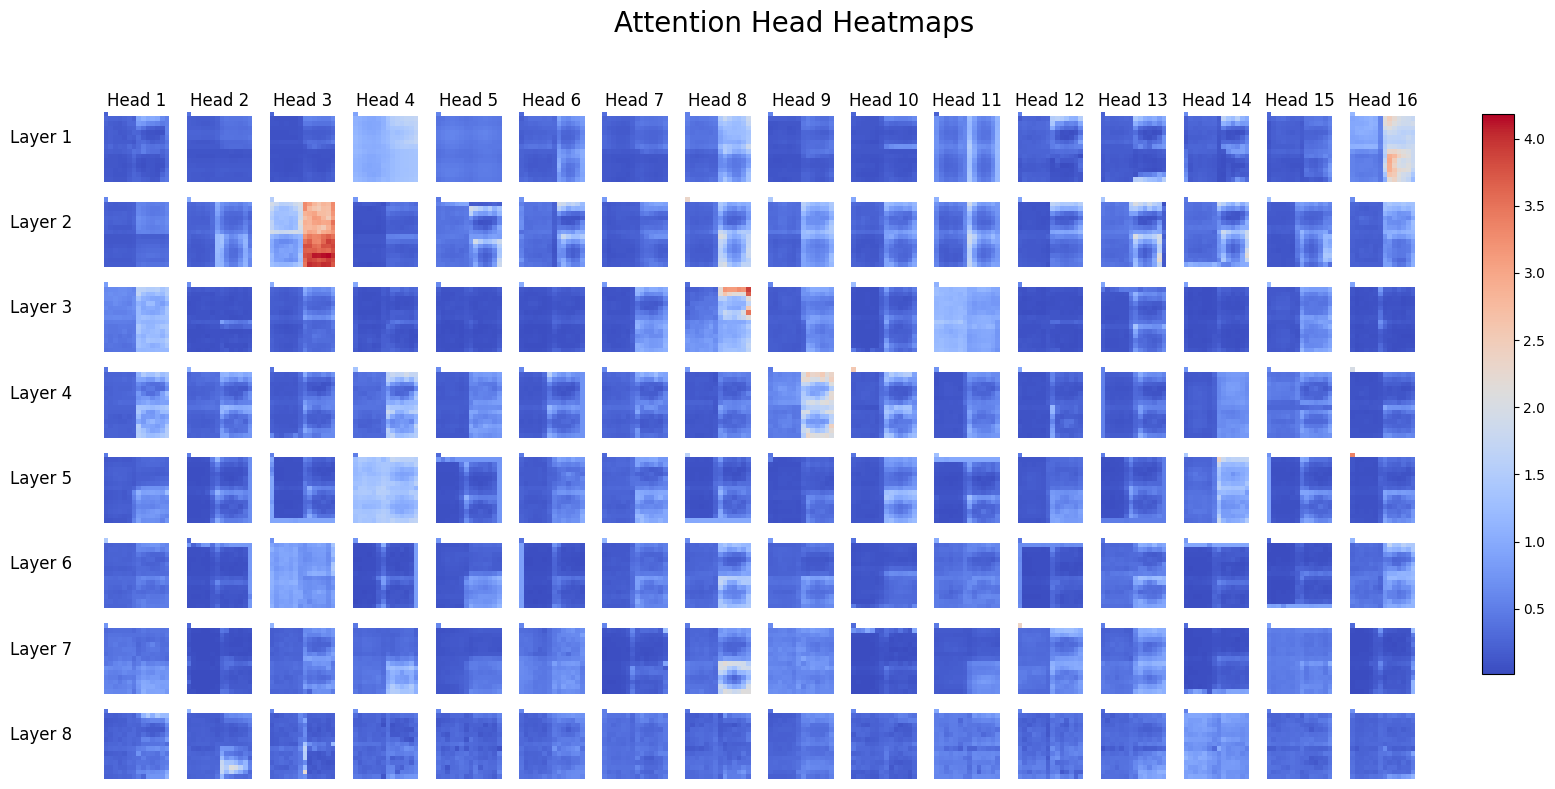

In [75]:
# Find global min and max for consistent color range across all heatmaps
global_min = stacked_matrix.min()
global_max = stacked_matrix.max()

batched_alpha_pixel = stacked_matrix[:, :1].squeeze()

# Set up the matplotlib figure with 24 rows and 16 columns for images and alpha_pixel indicators
fig, axes = plt.subplots(8, 16, figsize=(16, 8))  # Adjust the figure size as needed
fig.patch.set_facecolor('white')  # Set the background to white

# Generate heatmaps for each image with an additional alpha pixel
for i, ax in enumerate(axes.flatten()):
    # Create a 15x14 matrix with NaNs and place the alpha_pixel at the top left
    extended_matrix = np.full((15, 14), np.nan)
    extended_matrix[0, 0] = batched_alpha_pixel[i]  # Set the top left to the alpha_pixel value
    extended_matrix[1:, :] = batched_images[i]      # Place the original image below

    # Plot the extended heatmap
    sns.heatmap(extended_matrix, cmap='coolwarm', ax=ax, cbar=False, square=True,
                vmin=global_min, vmax=global_max, mask=np.isnan(extended_matrix))
    ax.set_xticks([])
    ax.set_yticks([])

# Create an axis for the color bar on the right side
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
norm = plt.Normalize(global_min, global_max)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

# Add the main title
plt.suptitle('Attention Head Heatmaps', fontsize=20)

# Set the labels for layers and heads
axes[0, 0].set_ylabel('Layer 1', rotation=0, size='large', labelpad=45)
for i in range(1, 8):
    axes[i, 0].set_ylabel(f'Layer {i+1}', rotation=0, size='large', labelpad=45)
for j in range(16):
    axes[0, j].set_xlabel(f'Head {j+1}', size='large')
    axes[0, j].xaxis.set_label_position('top') 

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the rect to account for the added colorbar axis
plt.show()

In [104]:
normed = stacked_matrix.norm(dim=-1)


In [103]:
stacked_matrix.shape

torch.Size([128, 197])

In [109]:
matrix_np_masked

array([[None, None, None, 17.21737289428711, None, None, None, None,
        None, None, None, None, None, None, None, 20.947856903076172],
       [None, None, 35.64493179321289, None, None, None, None, None,
        None, None, None, None, None, None, None, None],
       [13.269694328308105, None, None, None, None, None, None,
        17.31631088256836, None, None, 14.824000358581543, None, None,
        None, None, None],
       [None, None, None, None, None, None, None, None,
        17.764476776123047, None, None, None, None, None, None, None],
       [None, None, None, 18.502477645874023, None, None, None, None,
        None, None, None, None, None, 12.049981117248535, None, None],
       [None, None, 12.0611572265625, None, None, None, None, None, None,
        None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None

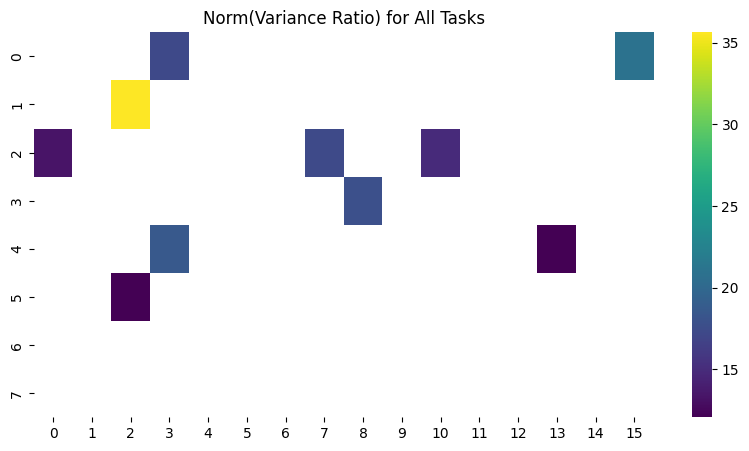

In [111]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example 1D tensor of shape [128]
# stacked_matrix = torch.rand(128)  # Assuming this is your tensor

# Reshape the tensor to 8 rows and 16 columns
reshaped_matrix = normed.reshape(8, 16)

# Convert to NumPy array for plotting
matrix_np = reshaped_matrix.numpy()  # If requires_grad=True for the tensor, use reshaped_matrix.detach().numpy()

# Set all the ones less than the top 10 as None and masked out
flat = matrix_np.flatten()
threshold = np.sort(flat)[-10]  # Find the 10th largest value
mask = matrix_np < threshold  # Create a mask for values below the threshold
matrix_np_masked = np.where(mask, np.nan, matrix_np)  # Apply mask and replace with np.nan instead of None
matrix_np_masked = matrix_np_masked.reshape(8, 16)
mask = mask.reshape(8, 16)

# Plotting the heatmap
plt.figure(figsize=(10, 5))  # Adjust the figure size as necessary
sns.heatmap(matrix_np_masked, annot=False, cmap='viridis', cbar=True, mask=np.isnan(matrix_np_masked))
plt.title('Norm(Variance Ratio) for All Tasks')
plt.show()


In [ ]:
stacked_matrix

In [96]:
# Plot the stacked_matrix on a heatmap

global_min = stacked_matrix.min()
global_max = stacked_matrix.max()

sns.heatmap(stacked_matrix, cmap='coolwarm', cbar=True, square=True,
            vmin=global_min, vmax=global_max)
plt.show()


IndexError: Inconsistent shape between the condition and the input (got (128, 1) and (128,))

ValueError: Must pass 2-d input. shape=()

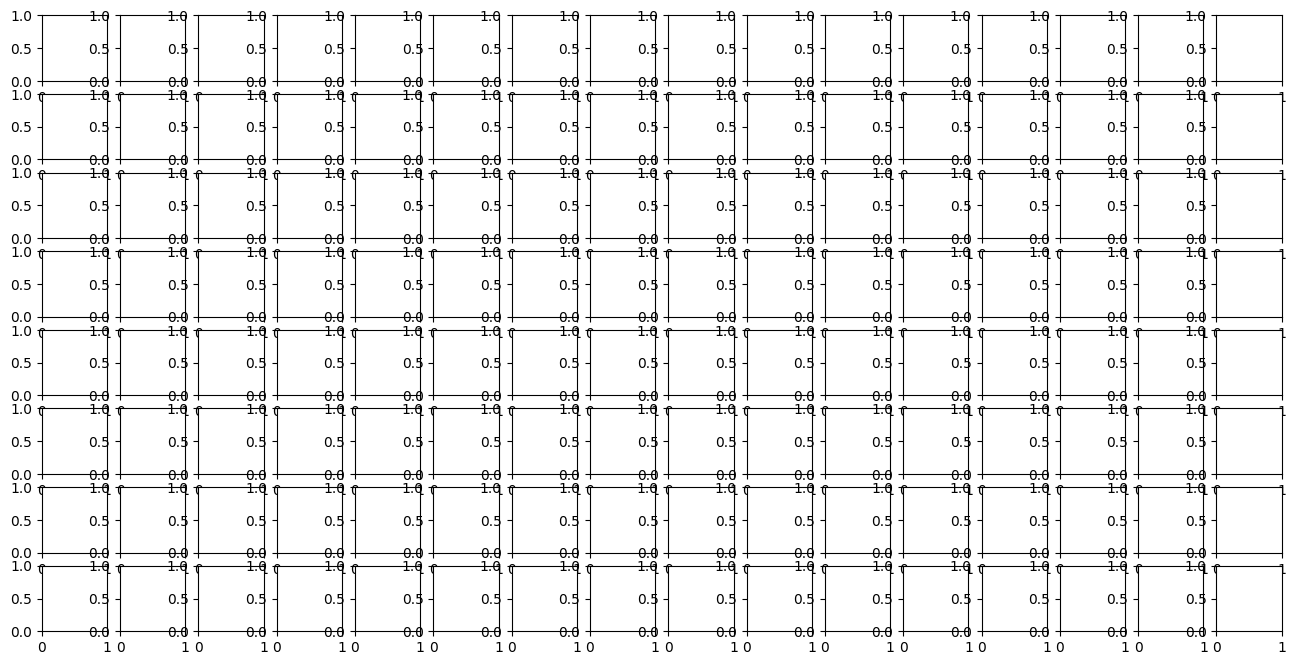

In [101]:
# Find global min and max for consistent color range across all heatmaps
global_min = stacked_matrix.min()
global_max = stacked_matrix.max()

batched_alpha_pixel = stacked_matrix[:, :1].squeeze()

# Set up the matplotlib figure with 24 rows and 16 columns for images and alpha_pixel indicators
fig, axes = plt.subplots(8, 16, figsize=(16, 8))  # Adjust the figure size as needed
fig.patch.set_facecolor('white')  # Set the background to white

# Generate heatmaps for each image with an additional alpha pixel
for i, ax in enumerate(axes.flatten()):
    # Create a 15x14 matrix with NaNs and place the alpha_pixel at the top left
    extended_matrix = np.full((15, 14), np.nan)
    extended_matrix[0, 0] = batched_alpha_pixel[i]  # Set the top left to the alpha_pixel value
    extended_matrix[1:, :] = batched_images[i]      # Place the original image below

    # Normalize the extended_matrix per heatma

    extended_matrix = np.linalg.norm(extended_matrix)
    # Plot the normalized extended heatmap
    sns.heatmap(np.array(extended_matrix), cmap='coolwarm', ax=ax, cbar=False, square=True,
                vmin=global_min, vmax=global_max)
    ax.set_xticks([])
    ax.set_yticks([])

# Create an axis for the color bar on the right side
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
norm = plt.Normalize(global_min, global_max)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

# Add the main title
plt.suptitle('Attention Head Heatmaps', fontsize=20)


# Set the labels for layers and heads
axes[0, 0].set_ylabel('Layer 1', rotation=0, size='large', labelpad=45)
for i in range(1, 8):
    axes[i, 0].set_ylabel(f'Layer {i+1}', rotation=0, size='large', labelpad=45)
for j in range(16):
    axes[0, j].set_xlabel(f'Head {j+1}', size='large')
    axes[0, j].xaxis.set_label_position('top') 

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the rect to account for the added colorbar axis
plt.show()

In [8]:
alpha_labels = ["colorization", "inpaint single random", "lowlight enhance", "segmentation"]

In [3]:
new = {}
new["encoder"] = {}
new["decoder"] = {}


In [11]:
# Open the file in read mode
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['segmentation']['encoder_latent'].shape[0]
    decoder_layers = first_element['segmentation']['decoder_latent'].shape[0]
    print(encoder_layers, decoder_layers)
    data_list = []
    data_list_2 = []
    labels_list = []
    for label_name in alpha_labels:
        item = h5file[...][label_name]['encoder_latent'][:, 0, :, :] 
        data_list.append(item)
        data_list_2.append(item - h5file[...][label_name+"_neutral"]['encoder_latent'][:, 0, :, :])
        labels_list.append(label_name)


24 8


TypeError: Accessing a group is done with bytes or str, not <class 'ellipsis'>

In [4]:
# Open the file in read mode
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['segmentation']['encoder_latent'].shape[0]
    decoder_layers = first_element['segmentation']['decoder_latent'].shape[0]
    print(encoder_layers, decoder_layers)
    data_list = []
    data_list_2 = []
    labels_list = []
    for pass_name, pass_group in tqdm(h5file.items()):
        if pass_name.startswith('pass_'):
            for label_name, label_group in pass_group.items():
                if label_name in alpha_labels:
                    item = label_group['encoder_latent'][:, 0, :, :] 
                    data_list.append(item)
                    labels_list.append(label_name)
                
tensors = torch.tensor(np.array(data_list))


for category in ["colorization", "inpaint single random", "lowlight enhance", "segmentation"]:
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category  # Ensure labels_list is in a compatible format
    
    curr = tensors[indices]
    avg = curr.mean(dim=0)

    new["encoder"][category] = {"avg": avg}

import pickle

with open('new.pkl', 'wb') as f:
    pickle.dump(new, f)

24 8


  0%|          | 0/170 [00:00<?, ?it/s]

100%|██████████| 170/170 [01:29<00:00,  1.91it/s]


In [2]:
import pickle

with open('new.pkl', 'rb') as f:
    new = pickle.load(f)

In [8]:
new["encoder"]["colorization"]["avg_delta"].shape

torch.Size([24, 148, 16, 64])

In [41]:
# Open the file in read mode
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['segmentation']['encoder_latent'].shape[0]
    decoder_layers = first_element['segmentation']['decoder_latent'].shape[0]
    print(encoder_layers, decoder_layers)
    data_list = []
    data_list_2 = []
    labels_list = []
    for pass_name, pass_group in tqdm(h5file.items()):
        if pass_name.startswith('pass_'):
            for label_name, label_group in pass_group.items():
                if label_name in alpha_labels:
                    item = label_group['decoder_latent'][:, 0, :, :] - pass_group[label_name+"_neutral"]['decoder_latent'][:, 0, :, :]
                    data_list.append(item)
                    labels_list.append(label_name)
                
tensors = torch.tensor(np.array(data_list))


24 8


  5%|▌         | 9/170 [00:03<01:13,  2.20it/s]

100%|██████████| 170/170 [01:22<00:00,  2.06it/s]


In [42]:
tensors

tensor([[[[[-2.1447e-02,  2.5358e-02,  1.1525e-02,  ..., -7.7724e-02,
            -5.4517e-03,  8.1882e-03],
           [ 6.5974e-02,  1.3981e-02,  6.5437e-03,  ...,  2.5349e-02,
            -5.1040e-02, -2.5599e-02],
           [-2.3630e-02, -1.4748e-01,  1.3988e-02,  ...,  1.5959e-02,
            -3.3170e-02, -1.1442e-02],
           ...,
           [-2.0477e-01, -1.7801e-01,  2.2512e-02,  ..., -1.0262e-01,
             5.4269e-02,  4.3964e-02],
           [ 7.1341e-03,  1.1817e-02,  8.6541e-02,  ..., -8.7932e-04,
            -7.2232e-02,  5.2723e-02],
           [-8.2428e-02,  9.5802e-02,  1.1444e-02,  ...,  2.6982e-02,
            -1.2464e-03, -1.0889e-02]],

          [[-8.9893e-03, -3.9783e-02,  3.6682e-02,  ..., -3.0422e-02,
            -4.8559e-02,  2.9090e-02],
           [-7.7298e-02, -5.5220e-02, -3.6172e-02,  ...,  1.9586e-02,
            -1.9318e-01,  9.2782e-02],
           [-4.2031e-02, -1.1055e-02,  2.0436e-02,  ..., -2.7049e-02,
            -4.4129e-02, -3.8610e-02],
 

In [28]:
h1_l3 = 

In [29]:
h1_l3.shape

torch.Size([680, 197, 32])

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch  # Ensure torch is importeda

In [52]:
head = 16 - 1
layer = 1 - 1

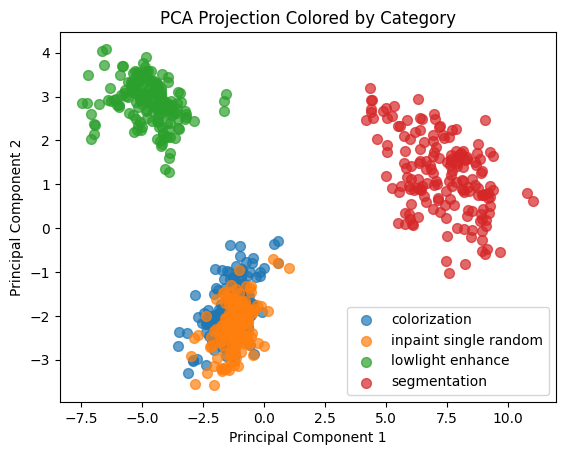

In [53]:
all_latents = tensors[:,layer,:,head,:].reshape(680,197*32).numpy()

pca = PCA(n_components=2)
pca_focus_result = pca.fit_transform(np.array(all_latents))

for category in ["colorization", "inpaint single random", "lowlight enhance", "segmentation"]:
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category  # Ensure labels_list is in a compatible format
    plt.scatter(pca_focus_result[indices, 0], pca_focus_result[indices, 1], s=50, alpha=0.7, label=category)  # Adjusted marker size

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

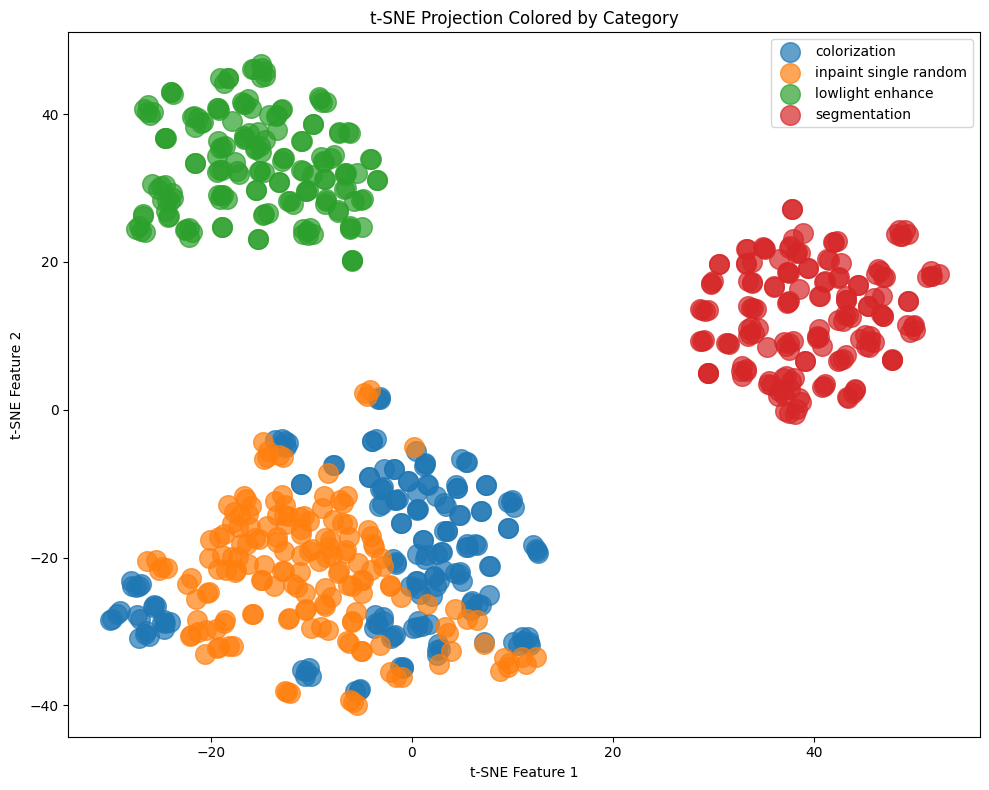

In [54]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(np.array(all_latents))

# Create a scatter plot
plt.figure(figsize=(10, 8))
for category in ["colorization", "inpaint single random", "lowlight enhance", "segmentation"]:
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 200, alpha=0.7, label=category)

# Add plot title, labels, and legend
plt.title('t-SNE Projection Colored by Category')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()  # Places the legend to the right of the plot

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()


In [11]:
# Open the file in read mode
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['segmentation']['encoder_latent'].shape[0]
    decoder_layers = first_element['segmentation']['decoder_latent'].shape[0]
    print(encoder_layers, decoder_layers)
    data_list = []
    data_list_2 = []
    labels_list = []
    for pass_name, pass_group in tqdm(h5file.items()):
        if pass_name.startswith('pass_'):
            for label_name, label_group in pass_group.items():
                if label_name in alpha_labels:
                    item = label_group['decoder_latent'][:, 0, :, :] - pass_group[label_name+"_neutral"]['decoder_latent'][:, 0, :, :]
                    data_list.append(item)
                    labels_list.append(label_name)
                
tensors = torch.tensor(np.array(data_list))

for category in ["colorization", "inpaint single random", "lowlight enhance", "segmentation"]:
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category  # Ensure labels_list is in a compatible format
    
    curr = tensors[indices]
    avg = curr.mean(dim=0)

    new["decoder"][category]["avg_delta"] = avg

import pickle

with open('new.pkl', 'wb') as f:
    pickle.dump(new, f)

24 8


100%|██████████| 170/170 [01:04<00:00,  2.65it/s]


In [12]:
new["decoder"]["colorization"]["avg_delta"].shape

torch.Size([8, 197, 16, 32])

In [ ]:
import pickle

with open('new.pkl', 'wb') as f:
    pickle.dump(new, f)

In [ ]:
new.keys()

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch  # Ensure torch is importeda



focus_labels = ["colorization", "inpaint single random", "lowlight enhance", "segmentation"]

focus_indices = [i for i, label in enumerate(labels_list) if label in focus_labels]
focus_latents = [data_list[i] for i in focus_indices]
focus_labels = [labels_list[i] for i in focus_indices]

tensor_list = torch.tensor(focus_latents)

#focus_labels = label_list
#focus_latents = all_latents


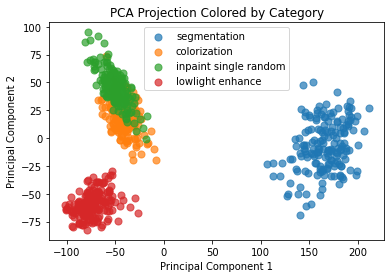

In [156]:


all_latents = torch.stack([latent.reshape(-1) for latent in tensor_list]).numpy()

pca = PCA(n_components=2)
pca_focus_result = pca.fit_transform(np.array(all_latents))

categories = list(set(focus_labels))
for category in categories:
    # Select rows that belong to the current category
    indices = np.array(focus_labels) == category  # Ensure labels_list is in a compatible format
    plt.scatter(pca_focus_result[indices, 0], pca_focus_result[indices, 1], s=50, alpha=0.7, label=category)  # Adjusted marker size

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()


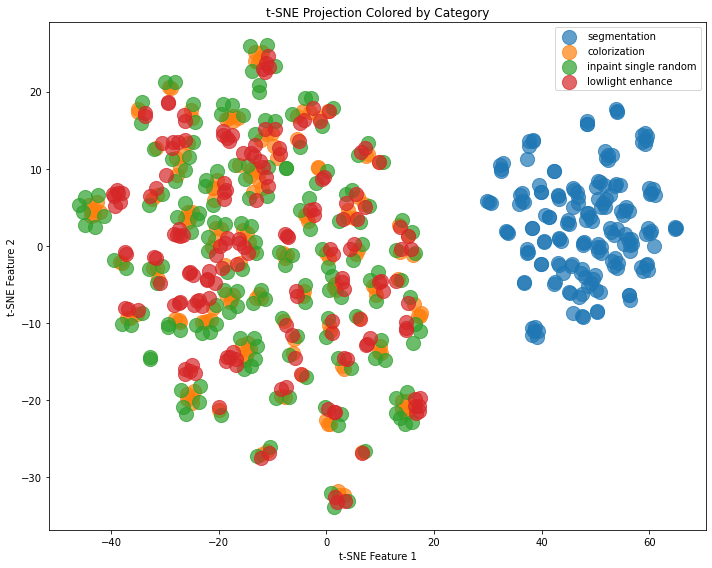

In [157]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(np.array(all_latents))

# Create a scatter plot
plt.figure(figsize=(10, 8))
categories = list(set(focus_labels))
for category in categories:
    # Select rows that belong to the current category
    indices = np.array(focus_labels) == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 200, alpha=0.7, label=category)

# Add plot title, labels, and legend
plt.title('t-SNE Projection Colored by Category')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()  # Places the legend to the right of the plot

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()


In [27]:

with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/improv_collec_notext_t1/dataset.hdf5", 'r') as h5file: 
    avg_tensors = {}
    for i in tqdm(range(len(labels))):
        tensor_holder = []
        for pass_name, pass_group in h5file.items():
            tensor_holder.append(pass_group[labels[i]]['decoder_latent'][:,0])        
        print(len(tensor_holder))
        current_average = np.array(tensor_holder).mean(0)
        avg_tensors[labels[i]] = current_average

 17%|█▋        | 1/6 [00:03<00:16,  3.30s/it]

170


 33%|███▎      | 2/6 [00:06<00:12,  3.18s/it]

170


 50%|█████     | 3/6 [00:09<00:09,  3.31s/it]

170


 67%|██████▋   | 4/6 [00:13<00:06,  3.47s/it]

170


 83%|████████▎ | 5/6 [00:16<00:03,  3.39s/it]

170


100%|██████████| 6/6 [00:20<00:00,  3.39s/it]

170


Encoder shape: (197, 512)


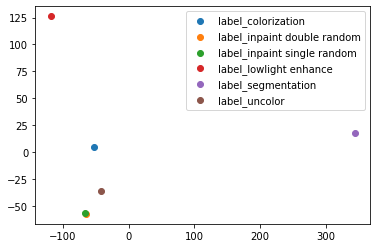

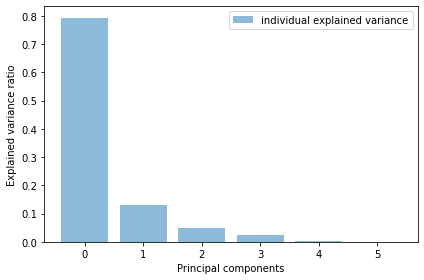

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the shape of the encoder
encoder_shape = avg_tensors["label_colorization"][0].shape
print(f'Encoder shape: {encoder_shape}')

# Reshape the encoder data and create a dataset
dataset = np.array([avg_tensors[k].reshape(-1) for k in avg_tensors.keys()])

# Perform PCA on the dataset
pca = PCA(n_components=6)
pca_result = pca.fit_transform(dataset)

# Plot the PCA result
for i, label in enumerate(avg_tensors.keys()):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], label=label)

plt.legend()
plt.show()

# Plot the variance that each PC captures
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(6, 4))
plt.bar(range(6), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [45]:
stacked_decoder_data = [ele.reshape(4096) for ele in decoder_data_list]
stacked_encoder_data = [ele.reshape(24576) for ele in encoder_data_list]